# Time series forecasting
This tutorial is inspired by a [Tensorflow Time Series Forecasting Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).
It implements the data analysis, plotting, and model training from scratch using Julia tools such as Plots.jl, Flux, and DataFrames.jl.

## Setup
Importing the usual suspects. Two interesting notes:
* StatsPlots re-exports Plots.jl functions, so we don't need that separately
* MLDataPattern is useful for preprocessing data for ML in a lazy (read: non-memory intensive) way. We will be seeing more of it

In [1]:
using ZipFile
using CSV
using DataFrames
using StatsPlots
using Dates
using FFTW
using CUDA
using Flux
using MLDataPattern

using Random: seed!
using Statistics: mean, std
using Flux: unsqueeze

Set a seed to make this reproducible.

In [2]:
seed!(4231)

ENV["LINES"] = 20;

Disallow scalar indexing for CUDA - prevents slow accesses to GPU memory

In [3]:
CUDA.allowscalar(false)

## The weather dataset
We are going to be using weather data for 7 years from the Max Planck Institute: https://www.bgc-jena.mpg.de/wetter/

In [4]:
function download_data(; fname="jena_climate_2009_2016.zip")
    DATA_PATH = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
    isfile(fname) || download(DATA_PATH, fname)

    zip = ZipFile.Reader(fname)
    csv = zip.files[1]
    df = CSV.File(csv) |> DataFrame
    close(zip)
    return df
end

download_data (generic function with 1 method)

More discussion on reading zipped CSVs here: https://juliadata.github.io/CSV.jl/stable/index.html#Example:-reading-from-a-zip-file-1

In [5]:
df = download_data();

df = df[6:6:end, :]

df[!,"Date Time"] = Dates.DateTime.(df[:,"Date Time"], "dd.mm.yyyy HH:MM:SS");

More info on working with dates and times: https://en.wikibooks.org/wiki/Introducing_Julia/Working_with_dates_and_times

In [6]:
col = ["Date Time", "T (degC)", "p (mbar)", "rho (g/m**3)"]

df[:,col]

70091×4 DataFrame
   Row │ Date Time            T (degC)  p (mbar)  rho (g/m**3) 
       │ DateTime             Float64   Float64   Float64      
───────┼───────────────────────────────────────────────────────
     1 │ 2009-01-01T01:00:00     -8.05    996.5        1307.86
     2 │ 2009-01-01T02:00:00     -8.88    996.62       1312.25
     3 │ 2009-01-01T03:00:00     -8.81    996.84       1312.18
     4 │ 2009-01-01T04:00:00     -9.05    996.99       1313.61
     5 │ 2009-01-01T05:00:00     -9.63    997.46       1317.19
     6 │ 2009-01-01T06:00:00     -9.67    997.71       1317.71
   ⋮   │          ⋮              ⋮         ⋮           ⋮
 70087 │ 2016-12-31T19:10:00     -0.98   1002.18       1280.7
 70088 │ 2016-12-31T20:10:00     -1.4    1001.4        1281.87
 70089 │ 2016-12-31T21:10:00     -2.75   1001.19       1288.02
 70090 │ 2016-12-31T22:10:00     -2.89   1000.65       1288.03
 70091 │ 2016-12-31T23:10:00     -3.93   1000.11       1292.41
                                             70080 rows omitted

One easy way to plot data from a datafrom is with the StatsPlots `@df` macro

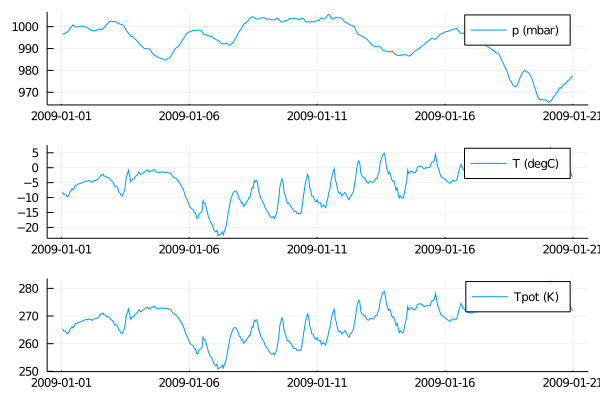

In [7]:
@df df plot(cols(1), cols(2:4); layout=(3, 1))

@df df[1:480,:] plot(cols(1), cols(2:4); layout=(3, 1))

## Inspect and cleanup

In [8]:
@show describe(df)

df."p (mbar)"; #cool that this works

describe(df) = 15×7 DataFrame
 Row │ variable         mean     min                  median  max                  nmissing  eltype
     │ Symbol           Union…   Any                  Union…  Any                  Int64     DataType
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Date Time                 2009-01-01T01:00:00          2016-12-31T23:10:00         0  DateTime
   2 │ p (mbar)         989.213  913.6                989.57  1015.29                     0  Float64
   3 │ T (degC)         9.45048  -22.76               9.41    37.28                       0  Float64
   4 │ Tpot (K)         283.493  250.85               283.46  311.21                      0  Float64
   5 │ Tdew (degC)      4.95647  -24.8                5.21    23.06                       0  Float64
   6 │ rh (%)           76.0098  13.88                79.3    100.0                       0  Float64
   7 │ VPmax (mbar)     13.5766  0.97                 11.8

Need to replace bad database values

In [9]:
replace!(df[!,"wv (m/s)"], -9999.0 => 0);
replace!(df[!,"max. wv (m/s)"], -9999.0 => 0);

@show describe(df)

describe(df) = 15×7 DataFrame
 Row │ variable         mean     min                  median  max                  nmissing  eltype
     │ Symbol           Union…   Any                  Union…  Any                  Int64     DataType
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Date Time                 2009-01-01T01:00:00          2016-12-31T23:10:00         0  DateTime
   2 │ p (mbar)         989.213  913.6                989.57  1015.29                     0  Float64
   3 │ T (degC)         9.45048  -22.76               9.41    37.28                       0  Float64
   4 │ Tpot (K)         283.493  250.85               283.46  311.21                      0  Float64
   5 │ Tdew (degC)      4.95647  -24.8                5.21    23.06                       0  Float64
   6 │ rh (%)           76.0098  13.88                79.3    100.0                       0  Float64
   7 │ VPmax (mbar)     13.5766  0.97                 11.8

15×7 DataFrame
 Row │ variable         mean     min                  median  max              ⋯
     │ Symbol           Union…   Any                  Union…  Any              ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Date Time                 2009-01-01T01:00:00          2016-12-31T23:10 ⋯
   2 │ p (mbar)         989.213  913.6                989.57  1015.29
   3 │ T (degC)         9.45048  -22.76               9.41    37.28
   4 │ Tpot (K)         283.493  250.85               283.46  311.21
   5 │ Tdew (degC)      4.95647  -24.8                5.21    23.06            ⋯
   6 │ rh (%)           76.0098  13.88                79.3    100.0
  ⋮  │        ⋮            ⋮              ⋮             ⋮              ⋮       ⋱
  11 │ H2OC (mmol/mol)  9.64044  0.81                 8.96    28.74
  12 │ rho (g/m**3)     1216.06  1059.45              1213.8  1393.54
  13 │ wv (m/s)         2.13054  0.0                  1.76    14.01            ⋯
  14 │ max. wv (m/s)    3.53367  0.0                  2.98    23.5
  15 │ wd (deg)         174.789  0.0                  198.1   360.0
                                                    3 columns and 4 rows omitted

## Feature engineering
Bucket wind direction and speed

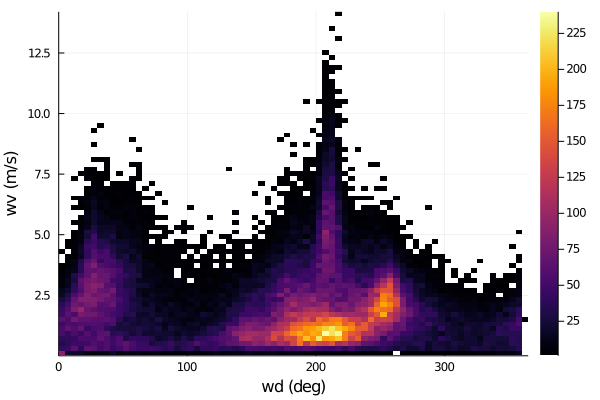

In [10]:
histogram2d(df[!,"wd (deg)"], df[!,"wv (m/s)"], bins=(75,75), xlabel="wd (deg)", ylabel="wv (m/s)")

It would be better to decompose this into X and Y velocities

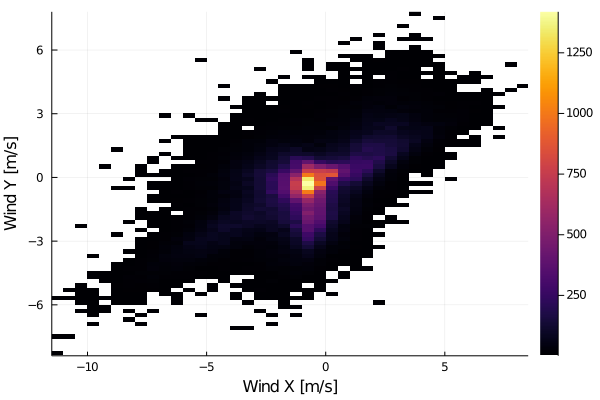

In [11]:
wd_rad = df[!,"wd (deg)"] * π / 180
df.Wx = df[!,"wv (m/s)"] .* cos.(wd_rad)
df.Wy = df[!,"wv (m/s)"] .* sin.(wd_rad)
df."max Wx" = df[!,"max. wv (m/s)"] .* cos.(wd_rad)
df."max Wy" = df[!,"max. wv (m/s)"] .* sin.(wd_rad);

histogram2d(df.Wx, df.Wy, bins=(75,75), xlabel="Wind X [m/s]", ylabel="Wind Y [m/s]")

Modify timestamp into a continuous "time of day" signal to deal with periodicity.

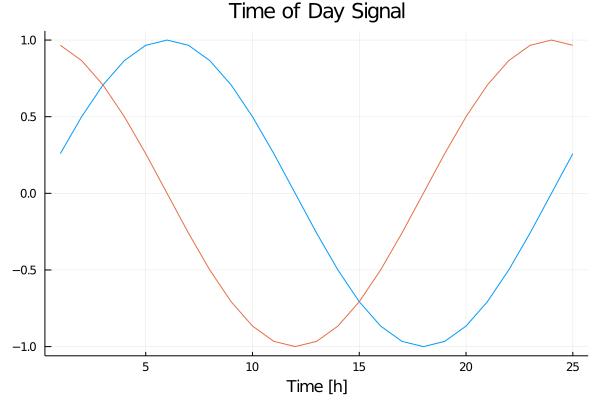

In [12]:
timestamp_s = Dates.datetime2unix.(df."Date Time");

day = 24*60*60 #seconds in a day
year = 365.2425 * day #seconds in a year

df[!,"Day sin"] = sin.(timestamp_s * (2 * π / day))
df[!,"Day cos"] = cos.(timestamp_s * (2 * π / day))
df[!,"Year sin"] = sin.(timestamp_s * (2 * π / year))
df[!,"Year cos"] = cos.(timestamp_s * (2 * π / year));

plot(df[1:25,"Day sin"], legend=false)
plot!(df[1:25,"Day cos"])
xlabel!("Time [h]")
title!("Time of Day Signal")

If you don't know the frequency to choose for your periodicity, you can take the FFT.
Here you can see that the yearly and daily periodicities are the most prominent.

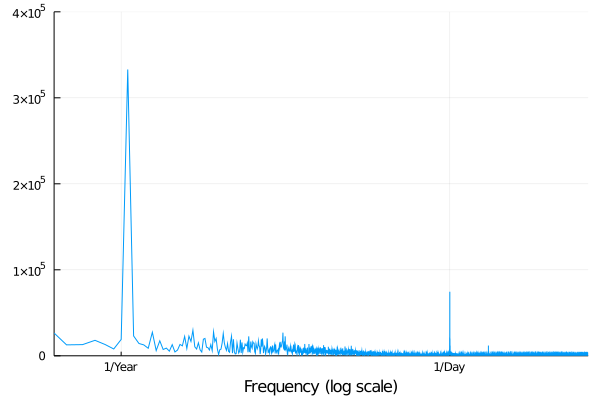

In [13]:
fftrans = FFTW.rfft(df[!,"T (degC)"])
f_per_dataset = 1:size(fftrans)[1]

n_samples_h = size(df[!,"T (degC)"])[1]
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / hours_per_year
f_per_year = f_per_dataset / years_per_dataset;

plot(f_per_year, abs.(fftrans), xscale=:log10, ylim=(0, 400000), xlim=(0.3,Inf), leg=false)
xticks!([1, 365.2524], ["1/Year", "1/Day"])
xlabel!("Frequency (log scale)")

## Split the data
Drop columns that won't be used further.

In [14]:
select!(df, Not([:("wv (m/s)"),:("max. wv (m/s)"), :("wd (deg)"), :("Date Time")]));

column_indices = pairs(names(df))
indices_columns = Dict(value => key for (key, value) in column_indices)
df = convert.(Float32, df) # Don't need high precision; reduces errors later on when using Params - gradients are Float32

70091×19 DataFrame
   Row │ p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)   VPmax (mbar)  VPa ⋯
       │ Float32   Float32   Float32   Float32      Float32  Float32       Flo ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │   996.5      -8.05    265.38        -8.78    94.4           3.33      ⋯
     2 │   996.62     -8.88    264.54        -9.77    93.2           3.12
     3 │   996.84     -8.81    264.59        -9.66    93.5           3.13
     4 │   996.99     -9.05    264.34       -10.02    92.6           3.07
     5 │   997.46     -9.63    263.72       -10.65    92.2           2.94      ⋯
     6 │   997.71     -9.67    263.66       -10.62    92.7           2.93
   ⋮   │    ⋮         ⋮         ⋮           ⋮          ⋮          ⋮            ⋱
 70087 │  1002.18     -0.98    272.01        -5.36    72.0           5.69
 70088 │  1001.4      -1.4     271.66        -6.84    66.29          5.51
 70089 │  1001.19     -2.75    270.32        -6.9     72.9           4.99      ⋯
 70090 │  1000.65     -2.89    270.22        -7.15    72.3           4.93
 70091 │  1000.11     -3.93    269.23        -8.09    72.6           4.56
                                               13 columns and 70080 rows omitted

Split the data into a training and validation set

In [15]:
n = size(df)[1]
train_df = df[1:round(Int,n*0.7, RoundDown),:]
valid_df = df[round(Int,n*0.7, RoundUp):round(Int,n*0.9, RoundDown),:]
test_df = df[round(Int,n*0.9, RoundUp):end,:]; # matching TF tutorial exactly, can also use partition

num_features = size(df,2)

19

## Normalize the data

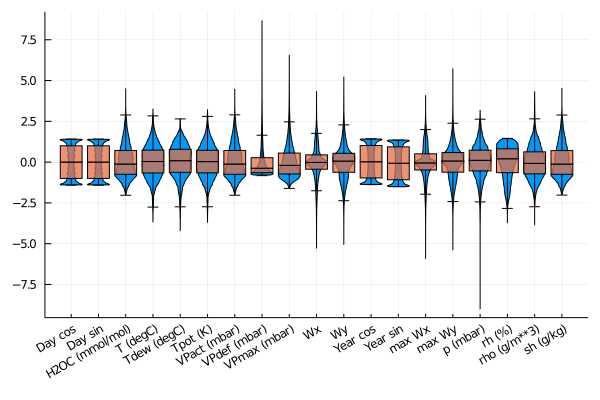

In [16]:
train_mean = mean.(eachcol(train_df))
train_std = std.(eachcol(train_df))

train_df = (train_df .- train_mean') ./ train_std'
valid_df = (valid_df .- train_mean') ./ train_std'
test_df = (test_df .- train_mean') ./ train_std'

df_std = (df .- train_mean') ./ train_std'
df_std = stack(df_std)

violin(df_std.variable, df_std.value, xrotation=30.0, legend=false, xticks=:all) # use plotattr() to learn about keywords
boxplot!(df_std.variable, df_std.value, fillalpha=0.75, outliers=false)

## Data Windowing
We will define our own WindowGenerator, some constructors, and plotting functions. The data from the WindowGenerator will be used in training.

In [17]:
include("window_generator.jl")

h = 6; # historical window length
f = 1; # future window length

WindowGenerator makes use of MLDataPattern's `slidingwindow` to generate the windows. It is good at flexibly generating sequences data, though requires a bit of mind-bending to fully understand how it generates sequences.
[slidingwindow docs](https://mldatapatternjl.readthedocs.io/en/latest/documentation/dataview.html?highlight=slidingwindow#labeled-windows)

In [18]:
slidingwindow(i -> i+h:i+h+f-1, Array(train_df)', h, stride=1)

49057-element slidingwindow(::Main.##722.var"#18#19", adjoint(::Matrix{Float32}), 6, stride = 1) with eltype Tuple:
 ([0.9453041 0.95976573 … 1.0610048 1.0911344; -1.9824733 -2.078372 … -2.1650276 -2.1696491; … ; -0.061052326 -0.060029317 … -0.056960337 -0.055937365; 1.428434 1.4284236 … 1.4283878 1.4283743], [1.1658554; -2.1118789; … ; -0.0549144; 1.4283602])
 ([0.95976573 0.9862837 … 1.0911344 1.1658554; -2.078372 -2.0702844 … -2.1696491 -2.1118789; … ; -0.060029317 -0.059006315 … -0.055937365 -0.0549144; 1.4284236 1.4284124 … 1.4283743 1.4283602], [1.2670871; -1.9882501; … ; -0.053891443; 1.4283456])
 ([0.9862837 1.0043571 … 1.1658554 1.2670871; -2.0702844 -2.098014 … -2.1118789 -1.9882501; … ; -0.059006315 -0.05798332 … -0.0549144 -0.053891443; 1.4284124 1.4284005 … 1.4283602 1.4283456], [1.3297591; -1.9374124; … ; -0.0528685; 1.42833])
 ([1.0043571 1.0610048 … 1.2670871 1.3297591; -2.098014 -2.1650276 … -1.9882501 -1.9374124; … ; -0.05798332 -0.056960337 … -0.053891443 -0.0528685;

WindowGenerator is implemented to make sequence-generating simpler. It uses `slidingwindow` behind the scenes to create sequences.

In [19]:
@doc WindowGenerator

Calculates the windows used for modeling, the target index, and features useful for plotting.

Specify `h` historical points, `f` target points. By default, the target points are assumed to follow after all the historical points (`offset = h`). By setting `offset = 1`, the targets for each historical point will be the next point in time.

WindowGenerator with a single label_column. 

WindowGenerator with multiple label_columns.


Create a WindowGenerator

In [20]:
wg = WindowGenerator(6, 1, train_df, valid_df, label_columns="T (degC)");

Plotting methods are implemented for raw data and with predictions.

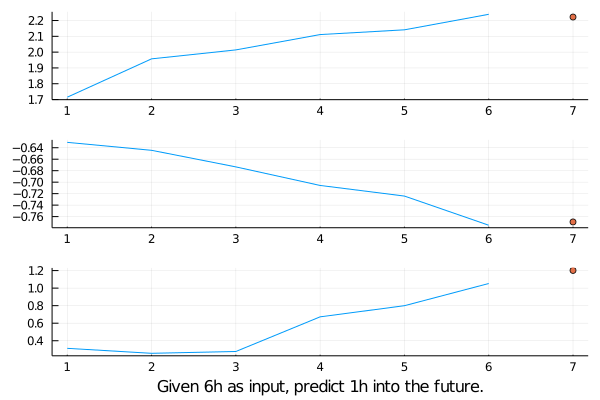

In [21]:
plot(wg)

We will also make use of the utility function for batching lazily-evaluated timeseries from slidingwindow

In [22]:
include("batch_ts.jl")

Main.##722.batch_ts

To understand better what all the above code does, let's look at an imitation training loop and look at everything's dimensions

In [23]:
practice_df = train_df[1:10,:]
a = slidingwindow(i -> i+h:i+h+f-1, Array(practice_df)', h, stride=1)

for i in eachbatch(shuffleobs(a), size=2)
    (x,y) = batch_ts(i)
    @show x
    @show y
    println()
end

x = Float32[0.9862837 1.0043571 1.0610048 1.0911344 1.1658554 1.2670871; -2.0702844 -2.098014 -2.1650276 -2.1696491 -2.1118789 -1.9882501; -2.1324346 -2.1610887 -2.2321506 -2.2390273 -2.1863046 -2.071688; -2.045187 -2.09682 -2.187178 -2.1828752 -2.108294 -1.9576976; 1.0627385 1.0083753 0.9842138 1.0144156 1.0264965 1.0204563; -1.328843 -1.3366406 -1.3535352 -1.3548348 -1.3405393 -1.3054504; -1.5272249 -1.5462353 -1.5795032 -1.5795032 -1.5509878 -1.4939572; -0.78834784 -0.7821209 -0.7821209 -0.78627217 -0.7841965 -0.7800452; -1.5287029 -1.5474207 -1.5811126 -1.5811126 -1.5549077 -1.4950107; -1.5319922 -1.5531187 -1.5859822 -1.5836347 -1.5578135 -1.4991288; 2.323999 2.3589115 2.4463177 2.4590142 2.416776 2.311058; 0.20798267 0.27034295 0.11226401 0.27458957 1.3088222 -0.0017026255; 0.276266 0.19526656 0.35081816 0.26863295 -0.008001719 -0.006444905; 0.11121804 0.24690734 0.048640482 0.17511468 1.2110392 -0.024096228; 0.32407838 0.14517556 0.40205324 0.37752837 0.057261467 0.0046644583; 1

That took the data at 10 timestamps (`train_df[1:10,:]`) and threw it into 4 'observations' using all the data it could while requesting 6 historical and 1 target point. This works out to the following:
* (1,2,3,4,5,6), 7
* (2,3,4,5,6,7), 8
* (3,4,5,6,7,8), 9
* (4,5,6,7,8,9), 10

It then shuffles these obserations, and lazily batches them into 2 batches each of size 2.

# Single Step Models

In [24]:
loss(x,y) = Flux.Losses.mse(x, y)

loss (generic function with 1 method)

### Baseline - 1h

In [25]:
struct Baseline
    label_index::Int
end

(m::Baseline)(x) = x[m.label_index,:,:]

target = "T (degC)"

"T (degC)"

Since this model repeats the last point, we make slidingwindows with 1 historical and 1 target point.

In [26]:
single_step_1h = WindowGenerator(1, 1, train_df, valid_df, label_columns=target);

baseline_model = Baseline(wg.target_idx[1])

Main.##722.Baseline(2)

Demonstrate the 'training error' for this model, although there is no actual training.

In [27]:
function run_single_step_baseline(wg, model)
    preds = Float32[]
    reals = Float32[]
    for (x,y) in wg.train
        val = model(x)[1]
        push!(preds, val)
        push!(reals, y[model.label_index])
    end

    l = loss(preds, reals)
    return l
end

run_single_step_baseline(single_step_1h, baseline_model)

0.013971615f0

### Baseline - 24h
Let's try to predict the next hour's value for 24 hours

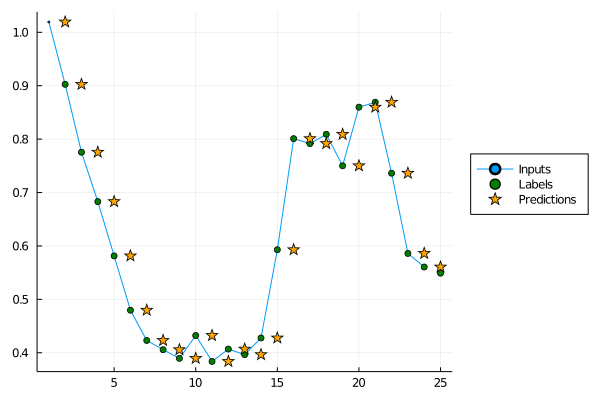

In [28]:
single_step_24h = WindowGenerator(24, 24, train_df, valid_df, label_columns=target; offset=1);

plot(single_step_24h, baseline_model)

### Linear Models
##### 1 hour
Set up a fairly generic training loop for the rest of the models. It takes in a model, and a WindowGenerator object, and uses the ADAM optimizer to train the model.

In [29]:
opt = Flux.Optimise.ADAM(0.01)

function train_model!(model, wg::WindowGenerator, opt; epochs=20, bs=16, dev=Flux.gpu)
    model = model |> dev
    ps = params(model)
    t = shuffleobs(wg.train)
    v = batch_ts(getobs(wg.valid))

    local l
    vl_prev = Inf
    for e in 1:epochs
        for d in eachbatch(t, size=bs)
            x, y = batch_ts(d)
            y = y[wg.target_idx,:,:]
            x, y = x |> dev, y |> dev
            gs = gradient(ps) do
                l = loss(model(x),y)
            end
            Flux.update!(opt, ps, gs)
        end
        l = round(l;digits=4)
        vl = round(loss(model(v[1]),v[2][wg.target_idx,:,:]); digits=4)
        println("Epoch $e/$epochs - train loss: $l, valid loss: $vl")
        #=
        crude early-stopping
        vl_prev < (vl - 0.001) && break
        vl_prev = vl
        =#
    end
    model = model |> cpu
end

train_model! (generic function with 1 method)

Now, train the linear model

In [30]:
linear = Dense(size(single_step_1h.train[1][1],1), 1; initW=Flux.glorot_uniform, initb=Flux.zeros)

@time linear = train_model!(linear, single_step_1h, opt; bs=32, epochs=20)

┌ Warning: The specified values for size and/or count will result in 6 unused data points
└ @ MLDataPattern /home/andrew/.julia/packages/MLDataPattern/KlSmO/src/dataview.jl:205
Epoch 1/20 - train loss: 0.0126, valid loss: 0.0094
Epoch 2/20 - train loss: 0.0112, valid loss: 0.009
Epoch 3/20 - train loss: 0.0112, valid loss: 0.009
Epoch 4/20 - train loss: 0.0112, valid loss: 0.009
Epoch 5/20 - train loss: 0.0112, valid loss: 0.009
Epoch 6/20 - train loss: 0.0112, valid loss: 0.009
Epoch 7/20 - train loss: 0.0111, valid loss: 0.009
Epoch 8/20 - train loss: 0.0111, valid loss: 0.009
Epoch 9/20 - train loss: 0.0111, valid loss: 0.009
Epoch 10/20 - train loss: 0.0111, valid loss: 0.009
Epoch 11/20 - train loss: 0.0111, valid loss: 0.009
Epoch 12/20 - train loss: 0.011, valid loss: 0.009
Epoch 13/20 - train loss: 0.011, valid loss: 0.009
Epoch 14/20 - train loss: 0.011, valid loss: 0.009
Epoch 15/20 - train loss: 0.011, valid loss: 0.009
Epoch 16/20 - train loss: 0.011, valid loss: 0.009
Epoc

Dense(19, 1)

##### 24 hours
Show the model's predictions for each point in the window.

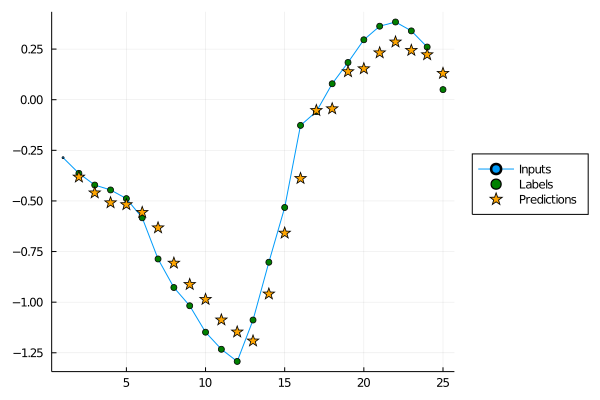

In [31]:
plot(single_step_24h, linear)

Visualize the weights of the linear regression. Naturally, since we are trying to predict future temperatures, we would expect that the current temperature is on of the most useful features.
This is shown by it having a high positive weight.

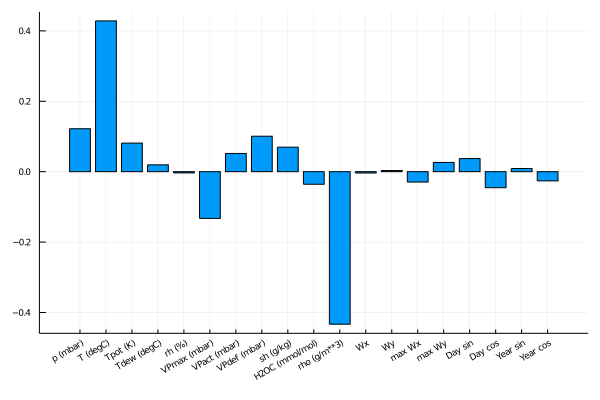

In [32]:
bar(names(train_df), linear.W[:], xrotation=30.0, legend=false, xticks=:all, tickfontsize=6)

### Dense
A model with 2 Fully-connected layers and relu non-linearities.

In [33]:
dense = Chain(
    Dense(19, 64, relu),
    Dense(64, 64, relu),
    Dense(64, 1)
)

@time dense = train_model!(dense, single_step_1h, opt; bs=32, epochs=20)

┌ Warning: The specified values for size and/or count will result in 6 unused data points
└ @ MLDataPattern /home/andrew/.julia/packages/MLDataPattern/KlSmO/src/dataview.jl:205
Epoch 1/20 - train loss: 0.0095, valid loss: 0.009
Epoch 2/20 - train loss: 0.0081, valid loss: 0.0089
Epoch 3/20 - train loss: 0.0079, valid loss: 0.0083
Epoch 4/20 - train loss: 0.008, valid loss: 0.0076
Epoch 5/20 - train loss: 0.0069, valid loss: 0.0072
Epoch 6/20 - train loss: 0.0066, valid loss: 0.0076
Epoch 7/20 - train loss: 0.0078, valid loss: 0.0074
Epoch 8/20 - train loss: 0.0046, valid loss: 0.0072
Epoch 9/20 - train loss: 0.0044, valid loss: 0.0069
Epoch 10/20 - train loss: 0.0053, valid loss: 0.0071
Epoch 11/20 - train loss: 0.005, valid loss: 0.0073
Epoch 12/20 - train loss: 0.0071, valid loss: 0.0072
Epoch 13/20 - train loss: 0.0057, valid loss: 0.0067
Epoch 14/20 - train loss: 0.0057, valid loss: 0.0071
Epoch 15/20 - train loss: 0.0059, valid loss: 0.0069
Epoch 16/20 - train loss: 0.0077, valid 

Chain(Dense(19, 64, relu), Dense(64, 64, relu), Dense(64, 1))

Dense model's predicions

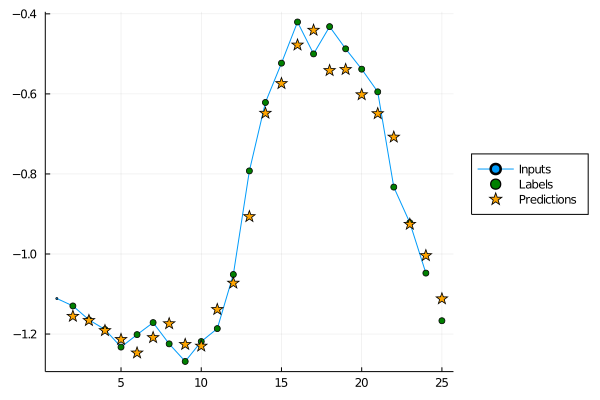

In [34]:
plot(single_step_24h, dense)

### Multi-step Dense
Now we are going to use 3 historical hours to predict 1 hour in the future.

In [35]:
single_step_3h = WindowGenerator(3, 1, train_df, valid_df, label_columns=target);

plot(single_step_3h)

multi_step_dense = Chain(
    i -> reshape(i, :, 1, size(i)[end]), # flatten first two dimensions, but preserve batch dimension
    Dense(19*3, 32, relu),
    Dense(32, 32, relu),
    Dense(32, 1)
)

@time multi_step_dense = train_model!(multi_step_dense, single_step_3h, opt; bs=32, epochs=20)

┌ Warning: The specified values for size and/or count will result in 4 unused data points
└ @ MLDataPattern /home/andrew/.julia/packages/MLDataPattern/KlSmO/src/dataview.jl:205
Epoch 1/20 - train loss: 0.0074, valid loss: 0.0088
Epoch 2/20 - train loss: 0.008, valid loss: 0.0092
Epoch 3/20 - train loss: 0.0065, valid loss: 0.0089
Epoch 4/20 - train loss: 0.0069, valid loss: 0.009
Epoch 5/20 - train loss: 0.0052, valid loss: 0.0088
Epoch 6/20 - train loss: 0.0057, valid loss: 0.0085
Epoch 7/20 - train loss: 0.006, valid loss: 0.009
Epoch 8/20 - train loss: 0.0072, valid loss: 0.0086
Epoch 9/20 - train loss: 0.0072, valid loss: 0.0087
Epoch 10/20 - train loss: 0.0073, valid loss: 0.008
Epoch 11/20 - train loss: 0.008, valid loss: 0.009
Epoch 12/20 - train loss: 0.0073, valid loss: 0.0088
Epoch 13/20 - train loss: 0.0076, valid loss: 0.0094
Epoch 14/20 - train loss: 0.0076, valid loss: 0.009
Epoch 15/20 - train loss: 0.0071, valid loss: 0.0089
Epoch 16/20 - train loss: 0.0074, valid loss:

Chain(#27, Dense(57, 32, relu), Dense(32, 32, relu), Dense(32, 1))

Show the model's 1 hour predicion using 3 hours of historical data.

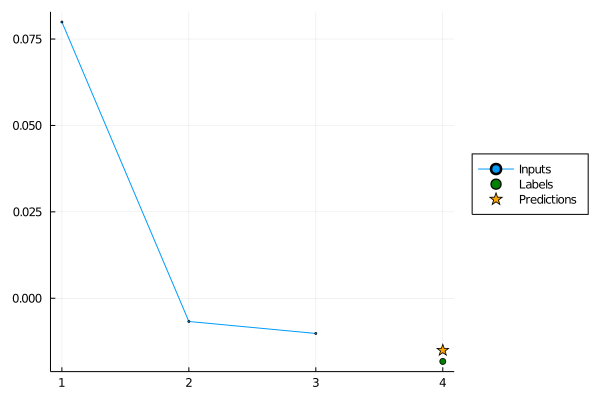

In [36]:
plot(single_step_3h, multi_step_dense)

### Convolutional Neural Network

conv_model = Chain(
    Conv((19,), 3=>32, relu), # need to explain why this conv pattern
    x -> Flux.flatten(x),
    Dense(32, 32, relu),
    Dense(32, 1),
    x -> unsqueeze(x, 1)
)

In [37]:
conv_model = Chain(
    x -> permutedims(x, [2,1,3]), # put data in NTime x NCovariates X NBatch https://github.com/FluxML/Flux.jl/issues/1465
    Conv((3,), 19=>32, relu), # convolve over 3 inputs - 19 variables -> 32 filters
    x -> Flux.flatten(x),
    Dense(32, 32, relu),
    Dense(32, 1),
    x -> unsqueeze(x, 1)
)

single_step_3h = WindowGenerator(3, 1, train_df, valid_df, label_columns=target);

@time conv_model = train_model!(conv_model, single_step_3h, opt; bs=32, epochs=20)

┌ Warning: The specified values for size and/or count will result in 4 unused data points
└ @ MLDataPattern /home/andrew/.julia/packages/MLDataPattern/KlSmO/src/dataview.jl:205
Epoch 1/20 - train loss: 0.0081, valid loss: 0.0084
Epoch 2/20 - train loss: 0.0064, valid loss: 0.0071
Epoch 3/20 - train loss: 0.0089, valid loss: 0.0082
Epoch 4/20 - train loss: 0.0081, valid loss: 0.008
Epoch 5/20 - train loss: 0.0084, valid loss: 0.0089
Epoch 6/20 - train loss: 0.0083, valid loss: 0.0083
Epoch 7/20 - train loss: 0.0084, valid loss: 0.0089
Epoch 8/20 - train loss: 0.0081, valid loss: 0.0084
Epoch 9/20 - train loss: 0.0093, valid loss: 0.0091
Epoch 10/20 - train loss: 0.0095, valid loss: 0.0094
Epoch 11/20 - train loss: 0.0099, valid loss: 0.0092
Epoch 12/20 - train loss: 0.0095, valid loss: 0.0096
Epoch 13/20 - train loss: 0.0101, valid loss: 0.0099
Epoch 14/20 - train loss: 0.0087, valid loss: 0.0091
Epoch 15/20 - train loss: 0.009, valid loss: 0.0096
Epoch 16/20 - train loss: 0.0082, valid

Chain(#29, Conv((3,), 19=>32, relu), #30, Dense(32, 32, relu), Dense(32, 1), #31)

Show the model's 1 hour predicion using 3 hours of historical data.

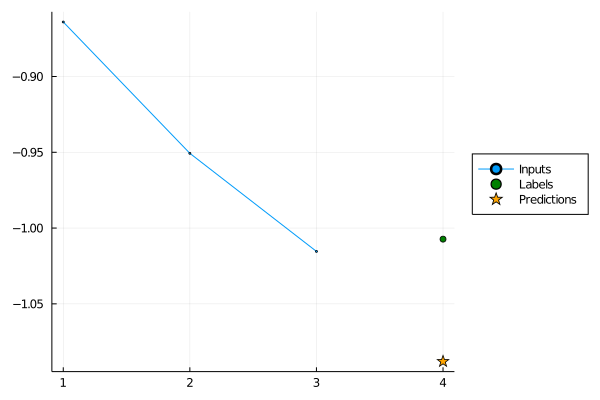

In [38]:
plot(single_step_3h, conv_model)

### Recurrent Neural Network

In [39]:
rnn_single_24h = Chain(
    LSTM(19, 32), # input features * output dimensionality
    Dense(32, 1),
    x->reshape(x,:) # lstm output * single number
)

Chain(Recur(LSTMCell(19, 32)), Dense(32, 1), #35)

Flux uses vectors of observations for RNNs, rather than the bulk tensor

In [40]:
a = [rand(Float32, 19) for i in 1:24]
b = rnn_single_24h.(a)
a[1]
rnn_single_24h(a[1])

1-element Vector{Float32}:
 -0.7347592

### Performance

### Multi-output Models

#### Baseline

#### Dense

#### RNN

#### Advanced: Residual Connections

#### Performance

# Multi-Step Models

### Baselines

## Single-shot Models

### Linear

### Dense

### CNN

### RNN

## Advanced Autoregressive model
### RNN

## Performance

Next Steps

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*